# Import lib

In [1]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q
!pip install accelerate -U
!pip install arabert
!pip install datasets
!nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 83.0 MB/s eta 0:00:

In [1]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import string
from transformers import pipeline, set_seed
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric, Dataset
from tqdm import tqdm
import torch
from sklearn.utils import shuffle

from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def is_any_word_in_text(substrings, text):
    pattern = '|'.join([re.escape(substring) for substring in substrings])
    match = re.search(pattern, text)
    return bool(match)

In [ ]:
def filterDataframeByKeywords(df, column_name, search_keywords):
    df['Match'] = df[column_name].apply(lambda x: is_any_word_in_text(search_keywords, x))
    filtered_df = df[df['Match']]
    filtered_df = filtered_df.drop(["Match"], axis=1).reset_index(drop=True)
    return filtered_df

In [ ]:
def combineDataframes(dataframes):
    combined_df = pd.concat(dataframes, ignore_index=True)
    combined_df.drop_duplicates(inplace=True)
    return combined_df

In [ ]:
def extractHistoricalData(df, column_name):
    pattern = r'\b\d{4}\b'

    filtered_df = df[df[column_name].str.contains(pattern, regex=True)]
    return filtered_df

In [ ]:
def count_record_with_words(df, col_name, keywords_list):
    count = 0

    for index, row in df.iterrows():
        text = row[col_name]
        if any(keyword in text for keyword in search_keywords):
            count += 1

    print(f"Number of records containing any of the search keywords: {count}")

In [ ]:
keywords_list = ["الله"
                 ,"محمد علي"
                 , "الملك"
                 , "مدينة"
                 , "رومان"
                 , "إمبراطور"
                 , "شعب"
                 , "بريطانيا"
                 , "عبد الناصر"
                 ,"القاهرة"
                 , "أكتوبر"
                 ,"فاروق"
                 , "الحياة"
                 , "الإسكندرية"
                 , "القديم"
                 , "عصر"
                 , "مسلم"
                 ,  "إسلام"
                 , "العالم"
                 , "عمر"
                 , "الفرنسية"
                 , "عرابي"
                 ,  'مصر'
                 , 'تاريخ'
                 , 'حضارة'
                 , 'سيسي'
                 , 'باشا'
                 , 'ثورة'
                 , 'عربي'
                 , 'مصري'
                 , 'مماليك'
                 , 'دولة'
                 , 'دين'
                 , 'حرب'
                 , 'جيش'
                 , 'حكم'
                 , 'بلاد'
                 , "رئيس"
                , "العراق"
                , "فتح"
                , "السلطان"
                , "بابل"
                , "قوات"
                , "رومان"
                , "فرنسا"]

# Working on xlsum dataset

In [ ]:
dataset_xlsum = load_dataset("csebuetnlp/xlsum", "arabic")

split_lengths = [len(dataset_xlsum[split])for split in dataset_xlsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_xlsum['train'].column_names}")
print("\nText:")

print(dataset_xlsum["test"][1]["text"])

print("\nSummary:")

print(dataset_xlsum["test"][1]["summary"])

In [ ]:
dataset_xlsum

In [ ]:
from datasets import concatenate_datasets


merged_xlsum_dataset = concatenate_datasets([dataset_xlsum["train"], dataset_xlsum["validation"], dataset_xlsum["test"]])

df_xlsum_merged = merged_xlsum_dataset.to_pandas()

print(df_xlsum_merged.shape)
print(df_xlsum_merged.columns)

In [ ]:
df_xlsum_merged.head()

In [ ]:
df_xlsum_merged = df_xlsum_merged.drop(["title", "url", "id"], axis=1)
df_xlsum_filtered = filterDataframeByKeywords(df_xlsum_merged, "summary", keywords_list)
df_xlsum_filtered['summary'], df_xlsum_filtered["text"] = df_xlsum_filtered["text"], df_xlsum_filtered['summary']
df_xlsum_filtered.rename(columns={'summary': 'text', "text": "summary"}, inplace=True)
df_xlsum_merged.head()

In [ ]:
print(df_xlsum_filtered.shape)
for i in range(5):
    print(f"summary {i}: ", df_xlsum_filtered.loc[i, "summary"])

# Working on labeld_validation dataset

In [ ]:
val_dataset = pd.read_json('/content/labeled_validation_dataset.jsonl', lines=True).drop(["example_id"], axis=1)
val_dataset.head()

In [ ]:
val_dataset.rename(columns={'paragraph': 'text'}, inplace=True)
val_dataset

# Concatenate the xlsum dataset and the validation dataset

In [ ]:
# Concatenate the data frames vertically (along rows)
concatenated_df = pd.concat([df_xlsum_filtered, val_dataset])

# Reset the index of the concatenated data frame
concatenated_df = concatenated_df.reset_index(drop=True)
concatenated_df.tail()

In [ ]:
concatenated_df.shape

In [ ]:
for i in range(5):
    print(f"summary {i}: ", concatenated_df.loc[i, "summary"])

In [ ]:
# concatenated_df.to_csv('xlsum_val_concatenated.csv', index=False)

# preprocess the data

In [ ]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import ISRIStemmer
from pyarabic.araby import strip_tashkeel

nltk.download('stopwords')
nltk.download('punkt')

# Initialize Arabic stopword list
stopwords_list = stopwords.words('arabic')

global count
count = 0

# Initialize Arabic stemmer
stemmer = ISRIStemmer()

def preprocess_arabic_text(text):
    # Text Cleaning
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags

    # Tokenization
    tokens = word_tokenize(text)

    # Stopword Removal
    tokens = [token for token in tokens if token not in stopwords_list]

    # Stemming
    tokens = [stemmer.stem(token) for token in tokens]

    # Remove diacritics
    tokens = [strip_tashkeel(token) for token in tokens]

    # Join the tokens back into a preprocessed text
    preprocessed_text = ' '.join(tokens)
    global count
    count += 1
    print(count)
    return preprocessed_text

def preprocess_arabic_summary(summary):
    # Text Cleaning
    summary = re.sub(r'<.*?>', '', summary)  # Remove HTML tags

    # Tokenization
    tokens = word_tokenize(summary)

    # Stopword Removal
    tokens = [token for token in tokens if token not in stopwords_list]

    # Remove diacritics
    tokens = [strip_tashkeel(token) for token in tokens]

    # Join the tokens back into a preprocessed summary
    preprocessed_summary = ' '.join(tokens)
    global count
    count += 1
    print(count)
    return preprocessed_summary


In [ ]:
# Preprocess the 'text' column
concatenated_df['text'] = concatenated_df['text'].apply(preprocess_arabic_text)
count = 0
# Preprocess the 'summary' column
concatenated_df['summary'] = concatenated_df['summary'].apply(preprocess_arabic_summary)

In [ ]:
for i in range(5):
    print(f"summary {i}: ", concatenated_df.loc[i, "summary"])

In [ ]:
def empty_rows(df):
    empty_index = [index for index,text in enumerate(df.text.values) if str(text).strip() == '']
    print(f"Number of empty text rows: {len(empty_index)}")
    return df.iloc[empty_index].tail()
empty_rows(concatenated_df)

In [ ]:
def delete_links(input_text):
    pettern  = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
    out_text = re.sub(pettern, ' ', input_text)
    return out_text

def delete_repeated_characters(input_text):
    pattern  = r'(.)\1{2,}'
    out_text = re.sub(pattern, r"\1\1", input_text)
    return out_text

def replace_letters(input_text):
    replace = {"أ": "ا","ة": "ه","إ": "ا","آ": "ا","": ""}
    replace = dict((re.escape(k), v) for k, v in replace.items())
    pattern = re.compile("|".join(replace.keys()))
    out_text = pattern.sub(lambda m: replace[re.escape(m.group(0))], input_text)
    return out_text

def clean_text(input_text):
    replace = r'[/(){}\[\]|@âÂ,;\?\'\"\*…؟–’،!&\+-:؛-]'
    out_text = re.sub(replace, " ", input_text)
    words = nltk.word_tokenize(out_text)
    words = [word for word in words if word.isalpha()]
    out_text = ' '.join(words)
    return out_text

def remove_vowelization(input_text):
    vowelization = re.compile(""" ّ|َ|ً|ُ|ٌ|ِ|ٍ|ْ|ـ""", re.VERBOSE)
    out_text = re.sub(vowelization, '', input_text)
    return out_text

def delete_stopwords(input_text):
    stop_words = set(nltk.corpus.stopwords.words("arabic") + nltk.corpus.stopwords.words("english"))
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    tokens = tokenizer.tokenize(input_text)
    wnl = nltk.WordNetLemmatizer()
    lemmatizedTokens =[wnl.lemmatize(t) for t in tokens]
    out_text = [w for w in lemmatizedTokens if not w in stop_words]
    out_text = ' '.join(out_text)
    return out_text

def stem_text(input_text):
    st = ISRIStemmer()
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    tokens = tokenizer.tokenize(input_text)
    out_text = [st.stem(w) for w in tokens]
    out_text = ' '.join(out_text)

    return out_text

def text_prepare(input_text, ar_text):
    out_text = delete_links(input_text)
    out_text = delete_repeated_characters(out_text)
    out_text = clean_text(out_text)
#     out_text = delete_stopwords(out_text)
    if ar_text:
        out_text = replace_letters(out_text)
        out_text = remove_vowelization(out_text)
    else:
        out_text = out_text.lower()
    return out_text


def applyingPipeline(dataframe):
    dataframe["text"] = dataframe["text"].apply(text_prepare, args=(True,))
    dataframe["summary"] = dataframe["summary"].apply(text_prepare, args=(True,))
    return dataframe


#df1 = applyingPipeline(df, "text", keywords_list)

In [ ]:
# concatenated_df = applyingPipeline(concatenated_df)

In [ ]:
# concatenated_df.to_csv('xlsum_val_concatenated_preprocessed.csv', index=False)

# read preprocessed data from csv file

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/ICMTC Competition/

/content/drive/MyDrive/ICMTC Competition


In [5]:
concatenated_df = pd.read_csv("/content/drive/MyDrive/ICMTC Competition/dataset/xlsum_val_concatenated_preprocessed.csv")
concatenated_df.head()

,text,summary
0,وكان رئس وكر ؤقت، كسندر تورتشينوف، امر سحب قوت...,بدأت القوات الأوكرانية الانسحاب جزيرة القرم .
1,حلل عام 2050 حاج مصر 21 لير متر كعب حصت حلي حس...,`` سيتم تغيير العبارة الشهيرة للمؤرخ اليوناني ...
2,ذكر وكل باء حلة ( جي.إن.إس ) جمع `` جيش حمد ''...,قالت الشرطة القطاع الهندي إقليم كشمير انفجار ق...
3,سلح حوث اب وقل صدر سلح حوث هجم شطء حرك همي إفش...,أكد مصدر `` الحراك التهامي '' لأبناء محافظة ال...
4,صعب قرب حسب ضرر سبب ازم لـ '' لكس فغن '' . فال...,تمر `` فولكس فاغن '' بأزمة عميقة، وهي شركة كبر...


In [ ]:
def get_sliced(df, percentage = 0.8, frac = 1, random_state = 123):
    # Shuffle the DataFrame
    shuffled_df = df.sample(frac=frac, random_state=random_state)

    # Calculate the number of rows for the slice
    slice_size = int(len(shuffled_df) * percentage)

    # Slice the DataFrame
    sliced_df = shuffled_df[:slice_size]
    return sliced_df.reset_index(drop=True)

In [ ]:
sliced_df = get_sliced(concatenated_df, 0.04)

In [ ]:
sliced_df.head()

,text,summary
0,قطع حطم نقل بعن فئق ارس مهد نقل عمل بحث عسكر د...,وصلت قطعة حطام طائرة، يعتقد الخبراء أنها ربما ...
1,كامير يعل استقالته ان خار نخب خرج تحد ورب أختا...,للمرة الأولى تاريخ الاتحاد الأوروبي تصوت احدى ...
2,يزد عرض هجر نطق عرق . أضف سيد `` زلن رتد لبس ص...,قالت سيدة عراقية الطائفة الأيزيدية محتجزة تنظي...
3,اقم غيلم كسك 20 عما وكان غيلم اهم كتب شعراء لغ...,توفي الشاعر الارجنتيني الكبير خوان غيلمان عمر ...
4,ركز قضة خدم نقل قئم طبق UberPop ، ربط خدم وبين...,قضت محكمة فرنسية بتغريم شركة `` أوبر '' لخدمات...


In [ ]:
sliced_df.shape

(1166, 2)

# Pretrained Model

In [6]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from arabert.preprocess import ArabertPreprocessor

#"abdalrahmanshahrour/arabartsummarization"
model_name="ahmeddbahaa/arabert2arabert-finetuned-ar-wikilingua"
preprocessor = ArabertPreprocessor(model_name="")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
pipeline = pipeline("text2text-generation",model=model,tokenizer=tokenizer)

# text = """وتحت عنوان من الكارثة إلى التحدى يبدأ الكاتب عرض الكتاب الرابع ، حيث يوضح كيف كانت إسرائيل فرحة بنصرها عام 67 وأنها ارتاحت لاعتقادها بأن هناك وقتا طويلا وطويلا جدا قبل أن يفيق العرب من صدمة 67، وكيف أن القوات الجوية للجمهورية العربية المتحدة قد فاجأتها بعد شهر واحد من نهاية حرب 67 بهجوم جوى عنيف على مواقعها فى سيناء وكان هذا إعلانا عن بداية حرب من نوع جديد هى حرب الاستنزاف التى استمرت حتى تم وقف إطلاق النار بين الطرفين فى 8 أغسطس 1970، ثم وفاة عبدالناصر وتولى أنور السادات حكم مصر واستعداده للحرب . ويتعرض الكاتب أيضا وبصورة سريعة لفلسطين والأردن وسوريا قبل أن ينتقل إلى الكتاب الخامس عن حرب أكتوبر ، حيث يعرض الخطط والاستعدادات المصرية ثم الاستعدادات الإسرائيلية ثم يبدأ بعرض وقائع الحرب بداية من الضربة الجوية وانهيار خط بارليف واختراقه ، ويتوقف الكاتب عند يوم 8 أكتوبر ، ويقول : إن هذا اليوم كان اسوأ هزيمة فى تاريخ الجيش الإسرائيلى ثم ينتقل بنا المؤلف إلى الجبهة السورية ثم يعود ثانية إلى يوميات الحرب حتى 7 9 أكتوبر إلى 9 13 أكتوبر ثم 14 أكتوبر ، ثم يعرض للثغرة أو ما عرف بعملية المزرعة الصينية يوم 16 و 15 أكتوبر والمساعدات الأمريكية الضخمة لإسرائيل ، ثم بداية الضغوط السياسية على الرئيس أنور السادات من 17 19 أكتوبر ثم ينتقل الكاتب للأحداث التى جرت من 17 20 أكتوبر وإعفاء الفريق الشاذلى من منصبه كرئيس لأركان القوات المسلحة المصرية ، وتولى الفريق الجمسى بدلا منه ثم الاتجاه إلى الموافقة على طلب وقف إطلاق النار والخلاف مع سوريا بشأن هذا الأمر ، ثم بداية الهجوم الإسرائيلى من 19 إلى 22 أكتوبر على الضفة الغربية لقناة السويس والعمليات النهائية فى سوريا 14 23 أكتوبر ، وكيف أن الملك حسين قرر دخول الحرب ضد إسرائيل يوم 9 أكتوبر ، ثم يعرض الكاتب المعركة الخاصة بالاستيلاء على مدينة السويس من 23 أكتوبر إلى 25 أكتوبر ثم تطورات هذه المعركة ، وكيف أنه مع حلول يوم السابع والعشرين من أكتوبر كان الإسرائيليون قد أسروا نحو ثمانية آلاف فرد من القوات المصرية ، أغلبهم من وحدات الإمداد والتموين"""
# text = preprocessor.preprocess(text)

# result = pipeline(text,
#             pad_token_id=tokenizer.eos_token_id,
#             num_beams=3,
#             repetition_penalty=3.0,
#             max_length=200,
#             length_penalty=1.0,
#             no_repeat_ngram_size = 3)[0]['generated_text']
# result

# Prepare data for finetuning

In [7]:
def make_dataset_from_dataframe(df, train_ratio= 0.8, val_ratio = 0.1, test_ratio = 0.1):
    # Shuffle the DataFrame
    df = shuffle(df, random_state=42)

    # Split the DataFrame into train, validation, and test sets
    train_size = int(train_ratio * len(df))
    val_size = int(val_ratio * len(df))
    test_size = len(df) - train_size - val_size


    train_df = df[:train_size]
    val_df = df[train_size : train_size + val_size]
    test_df = df[-test_size:]

    # Convert the train, validation, and test DataFrames to datasets.arrow_dataset.Dataset
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    test_dataset = Dataset.from_pandas(test_df)

    return train_dataset, val_dataset, test_dataset

In [8]:
train_dataset, val_dataset, test_dataset = make_dataset_from_dataframe(concatenated_df)

In [9]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset({
    features: ['text', 'summary', '__index_level_0__'],
    num_rows: 23322
})
Dataset({
    features: ['text', 'summary', '__index_level_0__'],
    num_rows: 2915
})
Dataset({
    features: ['text', 'summary', '__index_level_0__'],
    num_rows: 2916
})


In [9]:
train_dataset = train_dataset.remove_columns('__index_level_0__')
val_dataset = val_dataset.remove_columns('__index_level_0__')
test_dataset = test_dataset.remove_columns('__index_level_0__')

In [11]:
print("\nText:")

print(train_dataset["text"][0])

print("\nSummary:")

print(train_dataset["summary"][0])


Text:
فشل يهو شكل ئلف حكم خلل هلة 28 يوم ولى وقل يرز امم لفز استقباله يهو قره قدس سبت `` منح سبع اضافيين، وفق قانون، لاستكمال همة شكل حكم '' . وصل حدث شركاء حمل ئلف حكم طرق سدد نخب 22 يناير/كان ثني اضي . وذا يتم يهو شكل حكم حلل 16 مارس/آذار، مكن ان تتم دعة نخب جديدة، يلق ظلل الش زير قرر رئس امر برا اوب رائيل . وفي بين قضب جمع رئس اسرائيلي، لمح يهو ان شرك حمل وحد اقل ئلف رفض جلس بقة شركاء حمل . مواضيع تهم نهي طلب وجه يهو طلب حزب حلا ركز ثلث ربع وهم حزب `` وجد قبل '' حزب `` بيت يهد '' خفض عفء جند جبر خفض ميز اقتصادية منح دول يهد تشدد . وقل كبر فاض فرق يهو حدث ئلف يوم جمع بيت يهد ان حزب يمي رفض جلس حزب تشدد سؤل بيت يهد نفا . على رغم انه يسم حزب `` بيت يهد '' او حزب `` وجد قبل '' بشر كسبب عدم قدر شكل ئتلاف، يهو قال ان حزب قطع حزب خرى . وقل `` ابع ربع اضة حول شكل وسع حكم مكن ... عقد ان جمع ارثوذكسي تطرف سعد قبل ( طلب شركاء اخر ) سبب رئس عدم تمك كمل همة اليوم ... لأن قطع قطع بعن . '' كلف رئس يرز رسم يهو 2 شباط/فبراير اضي شكل حكم جدد اثر نخب عمة جرت 22 ثاني/يناير فزت لئح . همة شكل حكم وكانت 

# visualization

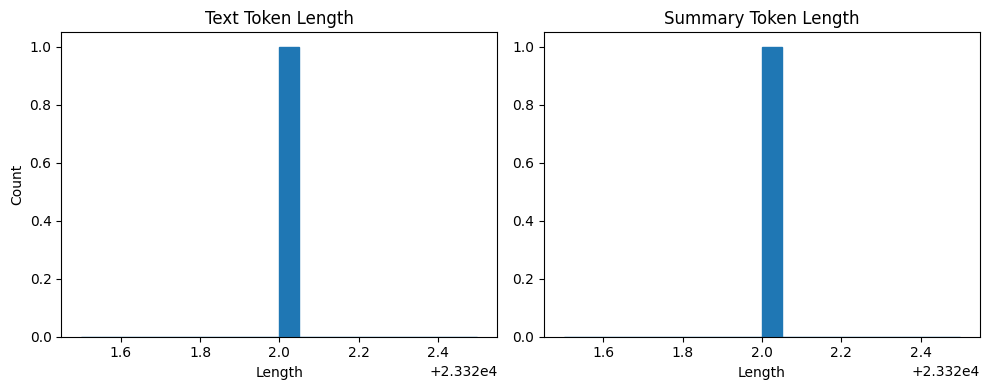

In [12]:
text_token_len = len([tokenizer.encode(s) for s in train_dataset["text"]])

summary_token_len = len([tokenizer.encode(s) for s in train_dataset["summary"]])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(text_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Text Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

# convert_examples_to_features

In [10]:
def convert_examples_to_features(example_batch):
    # max_length 1024 or 512
    input_encodings = tokenizer(example_batch['text'] , max_length = 512, truncation = True, padding="max_length", return_tensors="pt" )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

In [11]:
train_dataset_pt = train_dataset.map(convert_examples_to_features, batched = True)
test_dataset_pt = test_dataset.map(convert_examples_to_features, batched = True)
val_dataset_pt = val_dataset.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/23322 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3619: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/2916 [00:00<?, ? examples/s]

Map:   0%|          | 0/2915 [00:00<?, ? examples/s]

In [12]:
print(train_dataset_pt)
print("\nText:")
print(train_dataset_pt["text"][0])

print("\nSummary:")
print(train_dataset_pt["summary"][0])

print("\nInput_ids:")
print(train_dataset_pt["input_ids"][0])

print("\nAttention_mask:")
print(train_dataset_pt["attention_mask"][0])

print("\nLabels:")
print(train_dataset_pt["labels"][0])

Dataset({
    features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 23322
})

Text:
فشل يهو شكل ئلف حكم خلل هلة 28 يوم ولى وقل يرز امم لفز استقباله يهو قره قدس سبت `` منح سبع اضافيين، وفق قانون، لاستكمال همة شكل حكم '' . وصل حدث شركاء حمل ئلف حكم طرق سدد نخب 22 يناير/كان ثني اضي . وذا يتم يهو شكل حكم حلل 16 مارس/آذار، مكن ان تتم دعة نخب جديدة، يلق ظلل الش زير قرر رئس امر برا اوب رائيل . وفي بين قضب جمع رئس اسرائيلي، لمح يهو ان شرك حمل وحد اقل ئلف رفض جلس بقة شركاء حمل . مواضيع تهم نهي طلب وجه يهو طلب حزب حلا ركز ثلث ربع وهم حزب `` وجد قبل '' حزب `` بيت يهد '' خفض عفء جند جبر خفض ميز اقتصادية منح دول يهد تشدد . وقل كبر فاض فرق يهو حدث ئلف يوم جمع بيت يهد ان حزب يمي رفض جلس حزب تشدد سؤل بيت يهد نفا . على رغم انه يسم حزب `` بيت يهد '' او حزب `` وجد قبل '' بشر كسبب عدم قدر شكل ئتلاف، يهو قال ان حزب قطع حزب خرى . وقل `` ابع ربع اضة حول شكل وسع حكم مكن ... عقد ان جمع ارثوذكسي تطرف سعد قبل ( طلب شركاء اخر ) سبب رئس عدم تمك كمل همة اليوم ... لأن قطع قطع بعن . ''

# Train model

In [13]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [14]:
# from google.colab import drive
# drive.mount('/content/drive')

In [15]:
%cd /content/drive/MyDrive/ICMTC Competition/model

/content/drive/MyDrive/ICMTC Competition/model


In [16]:
from transformers import TrainingArguments, Trainer
trainer_args = TrainingArguments(
    output_dir='arabertWiki-xlsum', num_train_epochs=10, warmup_steps=500,
    per_device_train_batch_size=2, per_device_eval_batch_size=4,
    weight_decay=0.1, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=2,
    load_best_model_at_end=True  # Add load_best_model_at_end
)

In [17]:
from transformers import EarlyStoppingCallback
# Define the early stopping callback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=5)

trainer = Trainer(model=model, args=trainer_args,
                    tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                    train_dataset=train_dataset_pt,
                    eval_dataset=val_dataset_pt,
                    callbacks=[early_stopping_callback]  # Add the early stopping callback
)



In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:642: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to p

Step,Training Loss,Validation Loss
500,5.297500,5.010438
1000,4.712100,4.737174
1500,4.847100,4.620616
2000,4.546100,4.523669
2500,4.271500,4.429418
3000,3.659600,4.385649
3500,3.502700,4.373696
4000,3.612100,4.374640
4500,3.545400,4.328369
5000,3.563400,4.320208


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-3435b262f1ae>", line 1, in <cell line: 1>
    trainer.train()
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1645, in train
    return inner_training_loop(
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2020, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, model, trial, epoch, ignore_keys_for_eval)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2307, in _maybe_log_save_evaluate
    self.log(logs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2672, in log
    self.control = self.callback_handler.on_log(self.args, self.state, self.control, logs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer_callback.py"

In [18]:
#save model
model.save_pretrained("/content/drive/MyDrive/ICMTC competion/model/arabert-xlsum-model")

# Save tokenizer
tokenizer.save_pretrained("/content/drive/MyDrive/ICMTC competion/model/tokenizer")

('/content/drive/MyDrive/ICMTC competion/model/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/ICMTC competion/model/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/ICMTC competion/model/tokenizer/vocab.txt',
 '/content/drive/MyDrive/ICMTC competion/model/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/ICMTC competion/model/tokenizer/tokenizer.json')

# Evaluating the model

In [19]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [20]:


def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]



def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

rouge_metric = load_metric('rouge')

<ipython-input-21-67199026c897>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-67199026c897>", line 3, in <cell line: 3>
    rouge_metric = load_metric('rouge')
  File "/usr/local/lib/python3.10/dist-packages/datasets/utils/deprecation_utils.py", line 46, in wrapper
    return deprecated_function(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/datasets/load.py", line 1397, in load_metric
    metric_module = metric_module_factory(
  File "/usr/local/lib/python3.10/dist-packages/datasets/utils/deprecation_utils.py", line 46, in wrapper
    return deprecated_function(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/datasets/load.py", line 1328, in metric_module_factory
    raise e1 from None
  File "/usr/local/lib/python3.10/dist-packages/datasets/load.py", line 1320, in metric_module_factory
    ).get_module()
  Fil

In [ ]:
score = calculate_metric_on_test_ds(
    test_dataset_pt, rouge_metric, trainer.model, tokenizer, batch_size = 8, column_text = 'text', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['arabert'] )

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-e39e0537f5f9>", line 2, in <cell line: 1>
    test_dataset_pt, rouge_metric, trainer.model, tokenizer, batch_size = 8, column_text = 'text', column_summary= 'summary'
NameError: name 'rouge_metric' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(et

# all in one